# Custom AWS SageMaker Algorithm for Product Demand Forecast
Example of usage

In [3]:
import warnings
from io import StringIO
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.figsize'] = (16, 6)

In [4]:
import sagemaker as sage
from sagemaker import get_execution_role

sess = sage.Session()
role = get_execution_role()

## The Data
In this example we will use **Superstore sales data** that can be downloaded here: https://community.tableau.com/docs/DOC-1236

In [6]:
df_full = pd.read_excel('data/superstore.xls')

### Group by Month by Category

In [7]:
df_gr = df_full.groupby([pd.Grouper(key='Order Date', freq='MS'), 'Category'])['Sales'] \
    .sum() \
    .unstack() \
    .sort_values('Order Date')

df_gr = pd.DataFrame(df_gr.to_records())
df_gr.head()

,Order Date,Furniture,Office Supplies,Technology
0,2014-01-01,6242.525,4851.080,3143.290
1,2014-02-01,1839.658,1071.724,1608.510
2,2014-03-01,14573.956,8605.879,32511.174
3,2014-04-01,7944.837,11155.074,9195.434
4,2014-05-01,6912.787,7135.624,9599.876


### Looking at 'Furniture' Category 

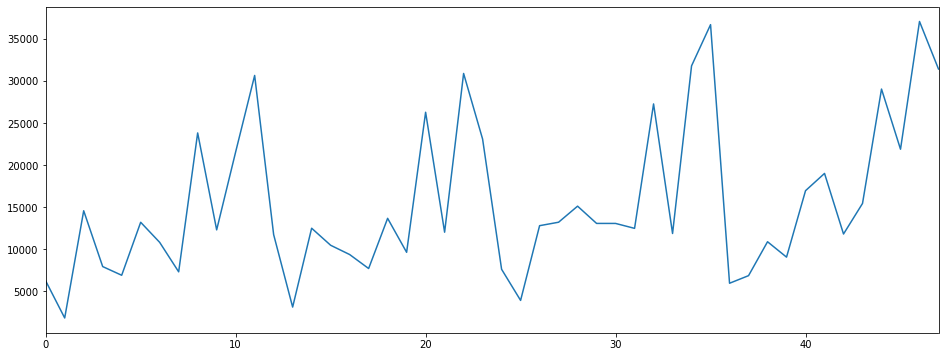

In [8]:
df_gr['Furniture'].plot()

### Dropping last few months so we can predict and compare this data

In [9]:
drop_month_count = 8

train_df = df_gr.iloc[:-drop_month_count]
real_df = df_gr.iloc[-drop_month_count:]

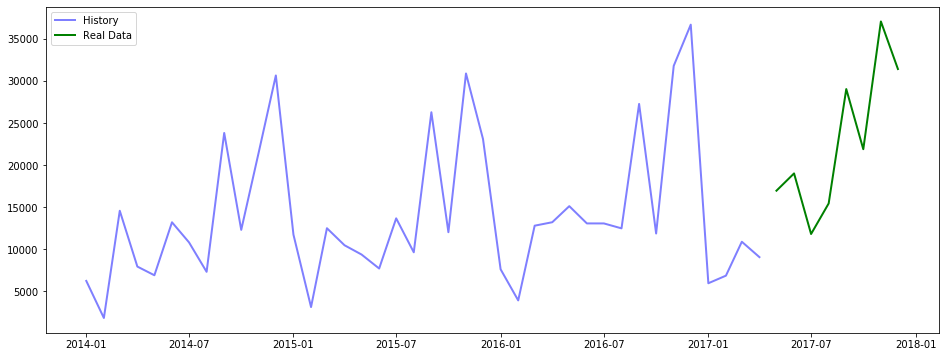

In [10]:
plt.plot( 'Order Date', 'Furniture', data=train_df, label='History', color='blue', alpha=0.5, linewidth=2)
plt.plot( 'Order Date', 'Furniture', data=real_df, label='Real Data',  color='green', linewidth=2)
plt.legend()

### Saving and uploading training data to S3

In [14]:
import os

input_upload_folder = 'data/usage-example/'
os.makedirs(input_upload_folder, exist_ok=True)

train_df.to_csv(input_upload_folder + 'superstore.csv', index=False)

In [15]:
# traine data info
s3_training_folder = 'forecaster-training-data'

train_data_location = sess.upload_data(input_upload_folder, key_prefix=s3_training_folder + '/input')
train_output_data_location = train_data_location.replace('/input', '/output')

train_data_location, train_output_data_location

('s3://sagemaker-us-west-2-664937856411/forecaster-training-data/input',
 's3://sagemaker-us-west-2-664937856411/forecaster-training-data/output')

## Predicting sales using our Forecaster algorithm on AWS Marketplace

You can find our model here: https://aws.amazon.com/marketplace/pp/prodview-56fo5it4n5mqm

### Training on SageMaker
Takes about 4 mins

In [ ]:
from utils import get_model_algorithm_arn

# container
algorithm_arn = get_model_algorithm_arn(sess.boto_region_name)

forecaster = sage.AlgorithmEstimator(algorithm_arn,
                       role, 1, train_instance_type='ml.c5.xlarge',
                       output_path=train_output_data_location,
                       sagemaker_session=sess)

forecaster.fit({'training': train_data_location})

#### Training job is completed. Now we can deploy the prediction endpoint or run Batch Transform job

### Deploying as an Endpoint
Takes about 7 mins

In [60]:
from sagemaker.predictor import json_serializer

predictor = forecaster.deploy(1, 'ml.c5.xlarge', serializer=json_serializer)

..........
----------------------------------------------------------------------------------!

#### Predicting missing months

In [61]:
result_str = predictor.predict({'new_points_count': drop_month_count, 'new_points_frequency': 'month'}).decode('utf-8')

In [62]:
drop_month_count

8

In [63]:
forecast = pd.read_csv(StringIO(result_str))
forecast.head()

,Order Date,Furniture,Office Supplies,Technology
0,2017-04-30,7798.989954,8089.130760,10010.227603
1,2017-05-31,11276.381406,14706.632102,14063.716082
2,2017-06-30,17588.796054,7786.672369,20612.190701
3,2017-07-31,11039.166281,20328.546773,28816.550003
4,2017-08-31,29463.640958,29574.656672,31696.015024


#### Cleanup

In [64]:
sess.delete_endpoint(predictor.endpoint)

#### Plotting prediction and real data for missing months

In [65]:
forecast['Order Date'] = pd.to_datetime(forecast['Order Date'])
forecast.head()

,Order Date,Furniture,Office Supplies,Technology
0,2017-04-30,7798.989954,8089.130760,10010.227603
1,2017-05-31,11276.381406,14706.632102,14063.716082
2,2017-06-30,17588.796054,7786.672369,20612.190701
3,2017-07-31,11039.166281,20328.546773,28816.550003
4,2017-08-31,29463.640958,29574.656672,31696.015024


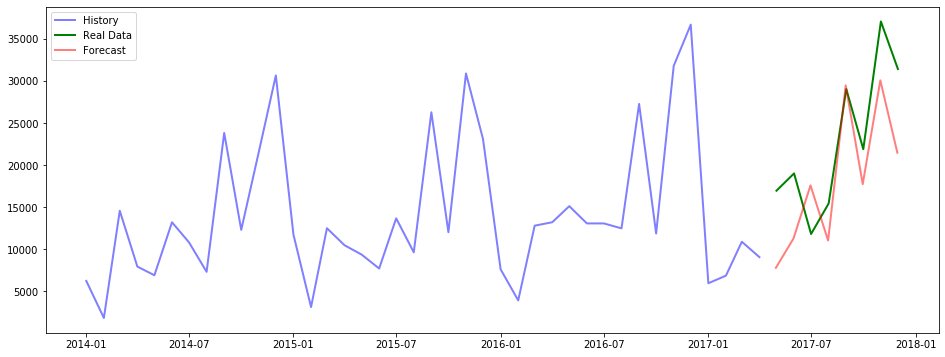

In [66]:
plt.plot( 'Order Date', 'Furniture', data=train_df, label='History', color='blue', alpha=0.5, linewidth=2)
plt.plot( 'Order Date', 'Furniture', data=real_df, label='Real Data',  color='green', linewidth=2)
plt.plot( 'Order Date', 'Furniture',  data=forecast, label='Forecast', color='red', alpha=0.5, linewidth=2)
plt.legend()

### Running as a Batch Transform job

In [82]:
batch_input_upload_folder = 'data/batch'

In [83]:
batch_data_location = sess.upload_data(batch_input_upload_folder, key_prefix=s3_training_folder + '/batch-input')

In [84]:
transform_output_folder = 'batch-transform-output'
transform_output_path="s3://{}/{}".format(sess.default_bucket(), transform_output_folder)

transform_instance_type = 'ml.c5.xlarge'
transformer = forecaster.transformer(instance_count=1,
                               instance_type=transform_instance_type,
                               output_path=transform_output_path,
                               assemble_with='Line',
                               accept='text/csv')

...........


In [85]:
batch_data_location, transform_output_path

('s3://sagemaker-us-east-2-992377156234/forecaster-training-data/batch-input',
 's3://sagemaker-us-east-2-992377156234/batch-transform-output')

In [86]:
transformer.transform(batch_data_location, content_type='application/json')
transformer.wait()

.................starting the server
Starting the inference server with 4 workers.
model_server_timeout is 300
started
[2019-12-27 14:40:24 +0000] [11] [INFO] Starting gunicorn 20.0.4
[2019-12-27 14:40:24 +0000] [11] [INFO] Listening at: unix:/tmp/gunicorn.sock (11)
[2019-12-27 14:40:24 +0000] [11] [INFO] Using worker: gevent
[2019-12-27 14:40:24 +0000] [15] [INFO] Booting worker with pid: 15
[2019-12-27 14:40:24 +0000] [16] [INFO] Booting worker with pid: 16
[2019-12-27 14:40:24 +0000] [17] [INFO] Booting worker with pid: 17
[2019-12-27 14:40:24 +0000] [18] [INFO] Booting worker with pid: 18

169.254.255.130 - - [27/Dec/2019:14:40:41 +0000] "GET /ping HTTP/1.1" 200 1 "-" "Go-http-client/1.1"
169.254.255.130 - - [27/Dec/2019:14:40:41 +0000] "GET /execution-parameters HTTP/1.1" 404 2 "-" "Go-http-client/1.1"
[VITECH] prediction called
[VITECH] Predicting new 8 records
169.254.255.130 - - [27/Dec/2019:14:40:41 +0000] "GET /ping HTTP/1.1" 200 1 "-" "Go-http-client/1.1"
169.254.255.130 - -

#### Download and display the result file

In [87]:
output_file_name = 'input1.json.out'
dest_path = 'data/usage-example-raw/' + output_file_name
s3_path = transform_output_folder + '/' + output_file_name

bucket = sess.boto_session.resource('s3').Bucket(sess.default_bucket())
bucket.download_file(s3_path, dest_path)

,Order Date,Furniture,Office Supplies,Technology
0,2017-04-30,7798.989954,8089.130760,10010.227603
1,2017-05-31,11276.381406,14706.632102,14063.716082
2,2017-06-30,17588.796054,7786.672369,20612.190701
3,2017-07-31,11039.166281,20328.546773,28816.550003
4,2017-08-31,29463.640958,29574.656672,31696.015024
5,2017-09-30,17733.927685,13481.936067,2000.946263
6,2017-10-31,30060.659337,38969.994756,32434.393596
7,2017-11-30,21468.182299,13340.180533,45121.055086


In [89]:
new_df = pd.read_csv(dest_path)
new_df['Order Date'] = pd.to_datetime(new_df['Order Date'])
new_df

,Order Date,Furniture,Office Supplies,Technology
0,2017-04-30,7798.989954,8089.130760,10010.227603
1,2017-05-31,11276.381406,14706.632102,14063.716082
2,2017-06-30,17588.796054,7786.672369,20612.190701
3,2017-07-31,11039.166281,20328.546773,28816.550003
4,2017-08-31,29463.640958,29574.656672,31696.015024
5,2017-09-30,17733.927685,13481.936067,2000.946263
6,2017-10-31,30060.659337,38969.994756,32434.393596
7,2017-11-30,21468.182299,13340.180533,45121.055086


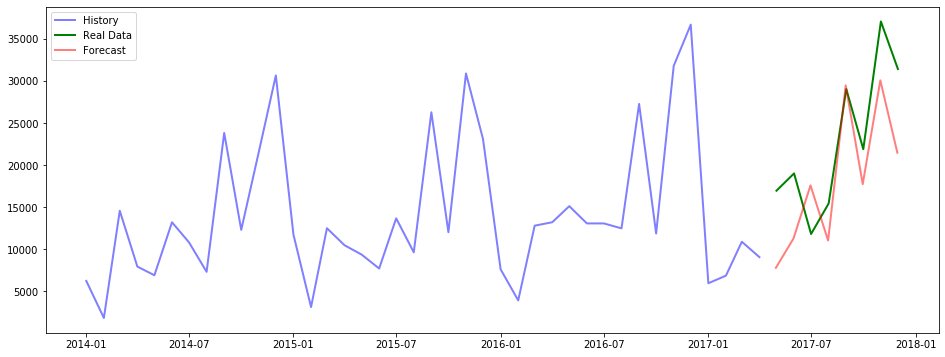

In [88]:
plt.plot( 'Order Date', 'Furniture', data=train_df, label='History', color='blue', alpha=0.5, linewidth=2)
plt.plot( 'Order Date', 'Furniture', data=real_df, label='Real Data',  color='green', linewidth=2)
plt.plot( 'Order Date', 'Furniture',  data=new_df, label='Forecast', color='red', alpha=0.5, linewidth=2)
plt.legend()